In [1]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from num2words import num2words
import spacy
from spacy.tokens import Doc
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression


In [2]:
pd.set_option('display.width', None)  # No truncation
pd.set_option('display.max_colwidth', None)  # Full content of each cell

In [3]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")


The first look at the dataset.Nothing interesting.

In [4]:
train_df.describe()

,review,sentiment
count,40000,40000
unique,39728,2
top,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.",positive
freq,5,20000


In [5]:
test_empty_values = test_df.isnull().sum().sum()
print(f"Number of empty values in test_df: {test_empty_values}")

train_empty_values = train_df.isnull().sum().sum()
print(f"Number of empty values in train_df: {train_empty_values}")

test_positive_count = test_df[test_df['sentiment'] == 'positive'].shape[0]
test_negative_count = test_df[test_df['sentiment'] == 'negative'].shape[0]
print(f"Positive values in test_df: {test_positive_count}")
print(f"Negative values in test_df: {test_negative_count}")

train_positive_count = train_df[train_df['sentiment'] == 'positive'].shape[0]
train_negative_count = train_df[train_df['sentiment'] == 'negative'].shape[0]
print(f"Positive values in train_df: {train_positive_count}")
print(f"Negative values in train_df: {train_negative_count}")


Number of empty values in test_df: 0
Number of empty values in train_df: 0
Positive values in test_df: 5000
Negative values in test_df: 5000
Positive values in train_df: 20000
Negative values in train_df: 20000


Now checking for imbalance, but the dataset is perfectly balanced. The test and train datasets are well-prepared. The original dataset contains about 50K movie reviews, with no empty values.

Now, we will check for any correlation between review length and sentiment. As you can see, the distributions of different sentiments look similar, so we cannot consider it an important feature.

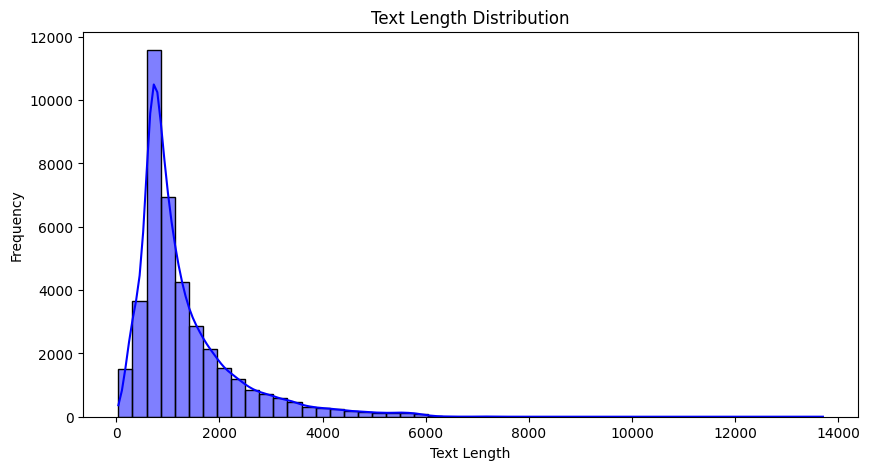

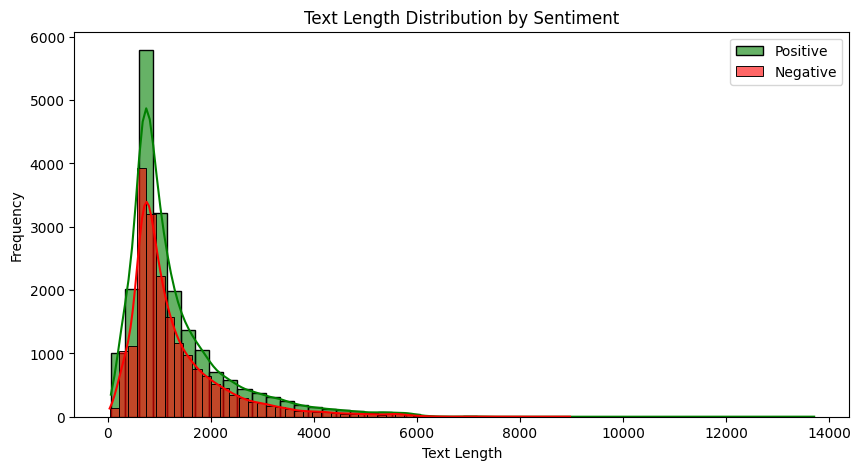

In [6]:

# Text Length Distribution Without Sentiment
plt.figure(figsize=(10, 5))
sns.histplot(train_df['review'].str.len(), bins=50, kde=True, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Text Length by Sentiment
plt.figure(figsize=(10, 5))
sns.histplot(train_df[train_df['sentiment'] == 'positive']['review'].str.len(), bins=50, kde=True, color='green', label='Positive', alpha=0.6)
sns.histplot(train_df[train_df['sentiment'] == 'negative']['review'].str.len(), bins=50, kde=True, color='red', label='Negative', alpha=0.6)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
train_df['sentiment'] = train_df['sentiment'].map({'negative': 0, 'positive': 1})
test_df['sentiment'] = test_df['sentiment'].map({'negative': 0, 'positive': 1})


Before proceeding further, I want to check the top words. As you can see, without preprocessing, we cannot extract meaningful information. The data is filled with stopwords and grammatical words that do not carry sentiment or meaning.

In [8]:

def plot_top_words_by_sentiment(df, column, sentiment_column, top_n=10):
    sentiments = df[sentiment_column].unique()
    
    for sentiment in sentiments:
        text = ' '.join([' '.join(tokens) if isinstance(tokens, list) else tokens for tokens in df[df[sentiment_column] == sentiment][column]])
        words = text.split()
        word_counts = Counter(words)
        common_words = word_counts.most_common(top_n)
        
        words, counts = zip(*common_words)
        plt.figure(figsize=(10, 5))
        plt.bar(words, counts)
        plt.xticks(rotation=45)
        plt.title(f'Top {top_n} Words for Sentiment {sentiment}')
        plt.xlabel('Words')
        plt.ylabel('Frequency')
        plt.show()



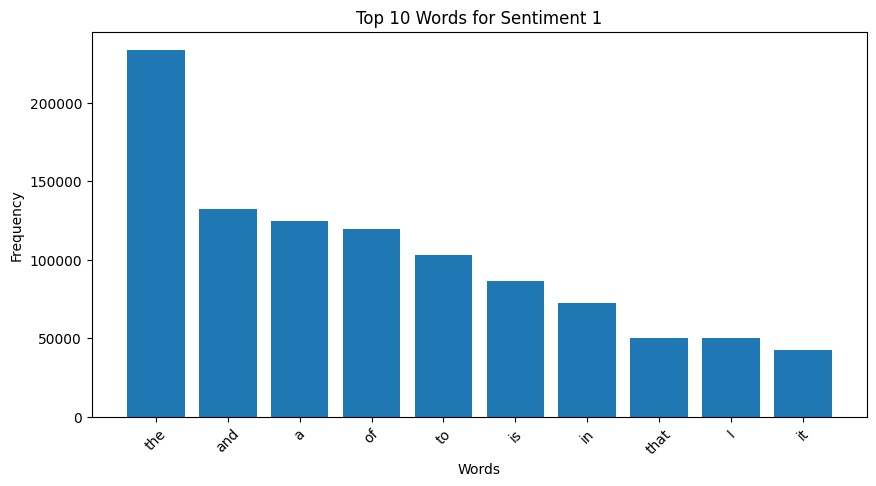

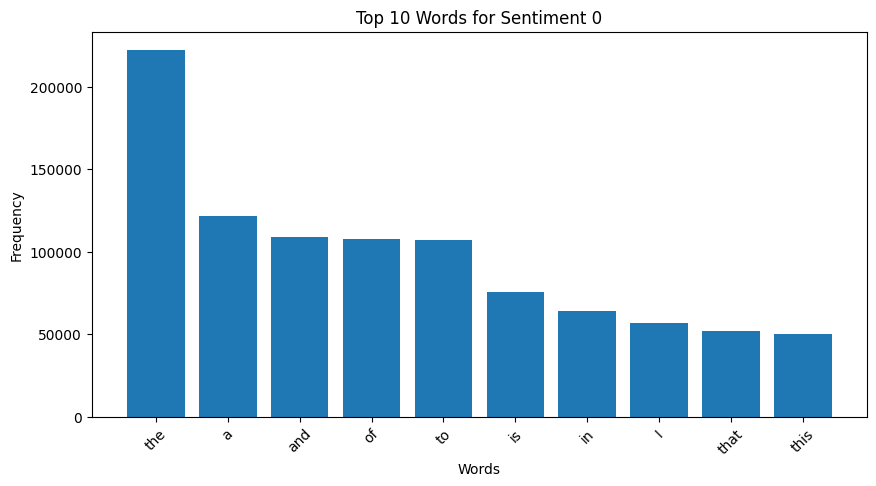

In [9]:
plot_top_words_by_sentiment(train_df, 'review', 'sentiment')

Now, I want to take an intuitive look at our reviews. This will help us gain insights into which preprocessing steps are necessary.

In [10]:
train_df.iloc[[0, 24000]]

,review,sentiment
0,"I caught this little gem totally by accident back in 1980 or '81. I was at a revival theatre to see two old silly sci-fi movies. The theatre was packed full and (with no warning) they showed a bunch of sci-fi short spoofs (to get us in the mood). Most were somewhat amusing but THIS came on and, within seconds, the audience was in hysterics! The biggest laugh came when they showed ""Princess Laia"" having huge cinnamon buns instead of hair on her head. She looks at the camera, gives a grim smile and nods. That made it even funnier! You gotta see ""Chewabacca"" played by what looks like a Muppet! It was extremely silly and stupid...but I couldn't stop laughing. Most of the dialogue was drowned out because of all the laughter. Also if you know ""Star Wars"" pretty well it's even funnier--they deliberately poke fun at some of the dialogue. This REALLY works with an audience! A definite 10!",1
24000,"One Night at McCool's is a very funny movie that is more intelligent than what it should be. Its form is more sophisticated than what I expected, and its randomness was superb. The thoughts behind the movie (mysogeny, sadism, stupid men) are are infantile. That's what I have to say about this movie is that not only does it hate women, but it loathes men. It doesn't have any sympathy for any of the men, really. It seems that way because of the form, but the ending says it all. Nobody cares.<br /><br />The form has the first 2/3 of the movie told in flashback by three characters: Dillon, the stupid bartender; Reiser, the mysogenistic stupid lawyer; and Goodman, the stupid, holier-than-thou cop. The story is therefore always perverted by their own self images and altered realities. Reiser's BBQ fantasy is a great touch. In the end, we never really know the truth, and nothing is what it seems. Dillon was never that innocent, etc. <br /><br />Actually, the rest of the movie is funny too. From the randomness of the last 5 seconds of the movie to the overly-obviousness of Tyler's manipulations, the movie seems to have an energy all its own. Everything is just out of the blue, and nothing seems to make sense. Do we really care if it does? No. <br /><br />It is also a very dark comedy, but has a shallow presentation. Think Nurse Betty, or Jawbreaker. Very candy coated outside, dark chewy inside. If you like your movies random, dark, or just purely mean, see this movie. This one will satisfy your urges for the strangeness that is One Night at McCool's.<br /><br />8/10",1


Now, we are creating the preprocessing steps. I have built a simple dictionary to convert popular internet vocabulary into more meaningful words. I included slang terms since this is a movie review dataset, not a formal document.

In [11]:

slang_dict = { 
    "lol": "laughing out loud",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "omg": "oh my god",
    "wtf": "what the heck",
    "brb": "be right back",
    "gtg": "got to go",
    "idk": "I don't know",
    "smh": "shaking my head",
    "btw": "by the way",
    "fyi": "for your information",
    "afk": "away from keyboard",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "tbh": "to be honest",
    "ikr": "I know, right?",
    "gg": "good game",
    "wp": "well played",
    "ez": "easy",
    "sus": "suspicious",
    "yeet": "to throw something with force / an exclamation of excitement",
    "noob": "newbie / inexperienced person",
    "rekt": "wrecked / badly defeated",
    "based": "acting independently and confidently",
    "cap": "lie / false statement",
    "simp": "someone who does too much for someone they like",
    "stan": "overly obsessed fan",
    "vibe": "a feeling or atmosphere",
    "clapback": "a witty or critical response",
    "mood": "relatable feeling or situation"
}

def convert_slang_words(text, slang_dict):
    pattern = r'\b(' + '|'.join(re.escape(key) for key in slang_dict.keys()) + r')\b'
    
    def replace_slang(match):
        return slang_dict[match.group(1).lower()]
    
    return re.sub(pattern, replace_slang, text, flags=re.IGNORECASE)

I also applied classical preprocessing steps common in nearly all NLP tasks, including removing irrelevant HTML tags, URLs, and punctuation. Additionally, I converted text to lowercase to ensure uniformity. I used a compound word separator as well. I aimed for simple functions—while more advanced tools are available, this initial approach yielded good results without requiring further methods.

In [12]:


def remove_html_tags(text):
    return re.sub(r'<[^>]+>', '', text)
    
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)
    
def convert_numbers_to_text(text):
    def replace_num(match):
        return num2words(int(match.group()))
    return re.sub(r'\b\d+\b', replace_num, text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def make_lowercase(text):
    return text.lower()
    
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

import wordninja

def split_compound_words(text):
    words = text.split()  
    return ' '.join([' '.join(wordninja.split(word)) for word in words])

def preprocess_text(text, slang_dict):
    text = convert_slang_words(text, slang_dict)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = convert_numbers_to_text(text)
    text = remove_punctuation(text)
    text = make_lowercase(text)
    text = split_compound_words(text)
    return text





In [13]:
train_df['review_prep'] = train_df['review'].apply(lambda x: preprocess_text(x, slang_dict))

Checking the changes in our texts after preprocessing.

In [14]:
train_df.iloc[[0, 24000]]

,review,sentiment,review_prep
0,"I caught this little gem totally by accident back in 1980 or '81. I was at a revival theatre to see two old silly sci-fi movies. The theatre was packed full and (with no warning) they showed a bunch of sci-fi short spoofs (to get us in the mood). Most were somewhat amusing but THIS came on and, within seconds, the audience was in hysterics! The biggest laugh came when they showed ""Princess Laia"" having huge cinnamon buns instead of hair on her head. She looks at the camera, gives a grim smile and nods. That made it even funnier! You gotta see ""Chewabacca"" played by what looks like a Muppet! It was extremely silly and stupid...but I couldn't stop laughing. Most of the dialogue was drowned out because of all the laughter. Also if you know ""Star Wars"" pretty well it's even funnier--they deliberately poke fun at some of the dialogue. This REALLY works with an audience! A definite 10!",1,i caught this little gem totally by accident back in one thousand nine hundred and eighty or eighty one i was at a revival theatre to see two old silly scifi movies the theatre was packed full and with no warning they showed a bunch of scifi short spoofs to get us in the rel a table feeling or situation most were somewhat amusing but this came on and within seconds the audience was in hysterics the biggest laugh came when they showed princess lai a having huge cinnamon buns instead of hair on her head she looks at the camera gives a grim smile and nods that made it even funnier you gotta see chew ab acca played by what looks like a muppet it was extremely silly and stupid but i couldnt stop laughing most of the dialogue was drowned out because of all the laughter also if you know star wars pretty well its even funnier they deliberately poke fun at some of the dialogue this really works with an audience a definite ten
24000,"One Night at McCool's is a very funny movie that is more intelligent than what it should be. Its form is more sophisticated than what I expected, and its randomness was superb. The thoughts behind the movie (mysogeny, sadism, stupid men) are are infantile. That's what I have to say about this movie is that not only does it hate women, but it loathes men. It doesn't have any sympathy for any of the men, really. It seems that way because of the form, but the ending says it all. Nobody cares.<br /><br />The form has the first 2/3 of the movie told in flashback by three characters: Dillon, the stupid bartender; Reiser, the mysogenistic stupid lawyer; and Goodman, the stupid, holier-than-thou cop. The story is therefore always perverted by their own self images and altered realities. Reiser's BBQ fantasy is a great touch. In the end, we never really know the truth, and nothing is what it seems. Dillon was never that innocent, etc. <br /><br />Actually, the rest of the movie is funny too. From the randomness of the last 5 seconds of the movie to the overly-obviousness of Tyler's manipulations, the movie seems to have an energy all its own. Everything is just out of the blue, and nothing seems to make sense. Do we really care if it does? No. <br /><br />It is also a very dark comedy, but has a shallow presentation. Think Nurse Betty, or Jawbreaker. Very candy coated outside, dark chewy inside. If you like your movies random, dark, or just purely mean, see this movie. This one will satisfy your urges for the strangeness that is One Night at McCool's.<br /><br />8/10",1,one night at mccool s is a very funny movie that is more intelligent than what it should be its form is more sophisticated than what i expected and its randomness was superb the thoughts behind the movie my so gen y sadism stupid men are are infantile that s what i have to say about this movie is that not only does it hate women but it loathes men it doesnt have any sympathy for any of the men really it seems that way because of the form but the ending says it all nobody cares the form has the first two three of the movie told in fla

Now, we need to tokenize our inputs for classical machine learning models. We must transform our input into features, as feeding raw text directly won’t yield meaningful results—except for SOTA models like LLMs. However, given the dataset size, using such models would be overkill and computationally expensive. Tokenization helps convert text into individual tokens. I used SpaCy’s advanced tokenizer, though a simpler tokenizer could also work. Additionally, I implemented batch processing and multi-threaded execution. I chose SpaCy over NLTK since it is Cython-based and generally faster.

In [15]:


nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def spacy_batch_tokenizer(texts, batch_size=None, n_threads=None, remove_stopwords=True, remove_short_tokens=True):
    """
    Efficiently tokenizes a list of texts using multi-threading and batch processing.
    
    :param texts: List of text strings
    :param batch_size: Number of texts processed in each batch (auto-adjusted if None)
    :param n_threads: Number of parallel processes (auto-adjusted if None)
    :param remove_stopwords: Remove stopwords
    :param remove_short_tokens: Remove tokens with length <= 2
    :return: List of tokenized texts
    """
    if n_threads is None:
        n_threads = os.cpu_count()  # Use max available CPU cores

    if batch_size is None:
        batch_size = min(256, len(texts) // n_threads)  # Auto-adjust batch size

    stop_words = nlp.Defaults.stop_words  # Pre-load stopwords

    # Convert to list before processing for faster execution
    docs = list(nlp.pipe(texts, batch_size=batch_size, n_process=n_threads))

    tokenized_texts = [
        [token.text for token in doc if (not remove_stopwords or token.text not in stop_words) and (not remove_short_tokens or len(token.text) > 2)]
        for doc in docs
    ]

    return tokenized_texts


After tokenization, we need to focus on the meaning of our tokens. Here, we have two main options: stemming and lemmatization. Stemming cuts words down to their root by removing suffixes, while lemmatization takes a more semantic approach to finding the base form of a word. The difference becomes clear after a few steps—it’s like night and day. Stemming is simpler and faster, whereas lemmatization requires extra resources. However, by efficiently combining tokenization and lemmatization, we can save processing time while maintaining better linguistic accuracy.

In [16]:
train_df["tokenized"] = spacy_batch_tokenizer(train_df["review_prep"].tolist())

In [17]:

stemmer = PorterStemmer()

def stem_tokens(token_list):
    return [stemmer.stem(token) for token in token_list]




In [18]:
train_df['stemmed'] = train_df['tokenized'].apply(stem_tokens)

In [19]:


n_threads = os.cpu_count()  # Use all available CPU cores


# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Only use tokenizer & lemmatizer

def spacy_lemmatize(tokenized_texts, batch_size=None, n_threads=-1):
    """
    Lemmatizes a list of already tokenized texts using spaCy.
    
    :param tokenized_texts: List of tokenized sentences (list of lists)
    :param batch_size: Batch size for processing
    :param n_threads: Number of threads
    :return: List of lemmatized token lists
    """
    lemmatized_texts = []
    batch_size = min(1024, len(tokenized_texts) // os.cpu_count())

    # Convert tokenized sentences into spaCy `Doc` objects
    docs = list(Doc(nlp.vocab, words=words) for words in tokenized_texts)

    # Process in parallel using `nlp.pipe`
    for doc in nlp.pipe(docs, batch_size=batch_size, n_process=n_threads):
        lemmatized_texts.append([token.lemma_ for token in doc])

    return lemmatized_texts


In [20]:
train_df["lemmatized"] = spacy_lemmatize(train_df["tokenized"].tolist())


In [21]:
train_df.iloc[[0, 24000]]

,review,sentiment,review_prep,tokenized,stemmed,lemmatized
0,"I caught this little gem totally by accident back in 1980 or '81. I was at a revival theatre to see two old silly sci-fi movies. The theatre was packed full and (with no warning) they showed a bunch of sci-fi short spoofs (to get us in the mood). Most were somewhat amusing but THIS came on and, within seconds, the audience was in hysterics! The biggest laugh came when they showed ""Princess Laia"" having huge cinnamon buns instead of hair on her head. She looks at the camera, gives a grim smile and nods. That made it even funnier! You gotta see ""Chewabacca"" played by what looks like a Muppet! It was extremely silly and stupid...but I couldn't stop laughing. Most of the dialogue was drowned out because of all the laughter. Also if you know ""Star Wars"" pretty well it's even funnier--they deliberately poke fun at some of the dialogue. This REALLY works with an audience! A definite 10!",1,i caught this little gem totally by accident back in one thousand nine hundred and eighty or eighty one i was at a revival theatre to see two old silly scifi movies the theatre was packed full and with no warning they showed a bunch of scifi short spoofs to get us in the rel a table feeling or situation most were somewhat amusing but this came on and within seconds the audience was in hysterics the biggest laugh came when they showed princess lai a having huge cinnamon buns instead of hair on her head she looks at the camera gives a grim smile and nods that made it even funnier you gotta see chew ab acca played by what looks like a muppet it was extremely silly and stupid but i couldnt stop laughing most of the dialogue was drowned out because of all the laughter also if you know star wars pretty well its even funnier they deliberately poke fun at some of the dialogue this really works with an audience a definite ten,"[caught, little, gem, totally, accident, thousand, eighty, eighty, revival, theatre, old, silly, scifi, movies, theatre, packed, warning, showed, bunch, scifi, short, spoofs, rel, table, feeling, situation, somewhat, amusing, came, seconds, audience, hysterics, biggest, laugh, came, showed, princess, lai, having, huge, cinnamon, buns, instead, hair, head, looks, camera, gives, grim, smile, nods, funnier, got, chew, acca, played, looks, like, muppet, extremely, silly, stupid, stop, laughing, dialogue, drowned, laughter, know, star, wars, pretty, funnier, deliberately, poke, fun, dialogue, works, audience, definite]","[caught, littl, gem, total, accid, thousand, eighti, eighti, reviv, theatr, old, silli, scifi, movi, theatr, pack, warn, show, bunch, scifi, short, spoof, rel, tabl, feel, situat, somewhat, amus, came, second, audienc, hyster, biggest, laugh, came, show, princess, lai, have, huge, cinnamon, bun, instead, hair, head, look, camera, give, grim, smile, nod, funnier, got, chew, acca, play, look, like, muppet, extrem, silli, stupid, stop, laugh, dialogu, drown, laughter, know, star, war, pretti, funnier, deliber, poke, fun, dialogu, work, audienc, definit]","[catch, little, gem, totally, accident, thousand, eighty, eighty, revival, theatre, old, silly, scifi, movie, theatre, pack, warning, show, bunch, scifi, short, spoofs, rel, table, feel, situation, somewhat, amusing, come, second, audience, hysteric, big, laugh, come, show, princess, lai, have, huge, cinnamon, bun, instead, hair, head, look, camera, give, grim, smile, nod, funny, get, chew, acca, play, look, like, muppet, extremely, silly, stupid, stop, laugh, dialogue, drown, laughter, know, star, war, pretty, funnier, deliberately, poke, fun, dialogue, work, audience, definite]"
24000,"One Night at McCool's is a very funny movie that is more intelligent than what it should be. Its form is more sophisticated than what I expected, and its randomness was superb. The thoughts behind the movie (mysogeny, sadism, stupid men) are are infantile. That's what I have to say about this movie is that not only does it h

Now, if we look at the top words again, we get more meaningful graphs. However, some words like *movie* and *film* still appear frequently. I am unsure whether removing these words is a good approach, as we have n-grams, and removing them could negatively impact the results.

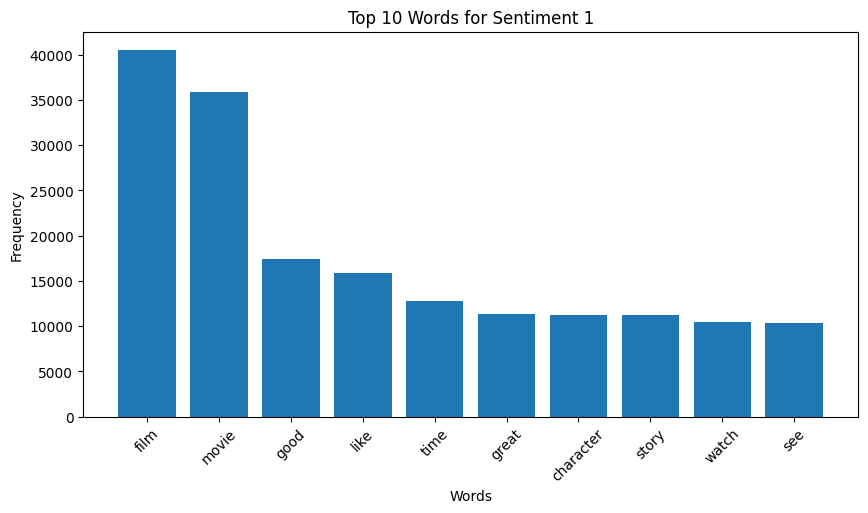

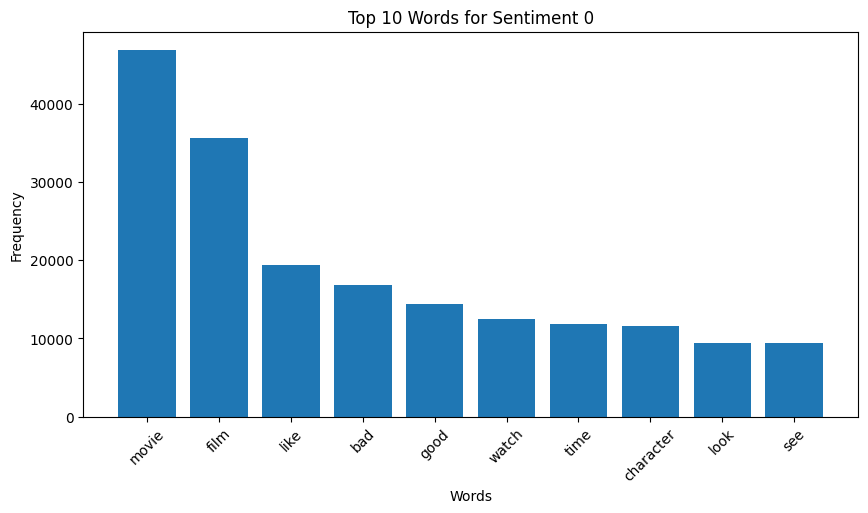

In [22]:
plot_top_words_by_sentiment(train_df, 'lemmatized', 'sentiment')

In [23]:


def identity_tokenizer(text):
    return text


tfidf_vectorizer = TfidfVectorizer(
    tokenizer=identity_tokenizer,
    preprocessor=None,
    token_pattern=None,
    lowercase=False, 
    max_features=20000,  
    ngram_range=(1,3),  # Use unigrams and bigrams 
    #sublinear_tf=True,  # Log-scale term frequencies
    min_df=2,  # Ignore words that appear in less than 2 documents
    max_df=0.95  # Ignore extremely common words
)


In [24]:
tfidf_matrix_ngram = tfidf_vectorizer.fit_transform(train_df['lemmatized'])

Now, since machine learning models are essentially mathematical functions, we cannot input raw text and expect meaningful results. Before feeding data into the model, we need to convert tokens into a vector representation. This transformation allows the model to process textual data numerically. I will use two primary approaches, including n-grams, which consider multiple token sequences like *good* or *not good* to preserve contextual meaning.

I also experimented with various parameters, such as limiting the number of features, adjusting n-gram options, and filtering out either the least or most frequently used words to improve model performance.

In [25]:


def identity_tokenizer(text):
    return text  # Assuming input is already tokenized

bow_vectorizer = CountVectorizer(
    tokenizer=identity_tokenizer,
    preprocessor=None,
    token_pattern=None,
    lowercase=False,
    max_features=20000,  # Limit vocabulary size
    ngram_range=(1, 3),
    min_df=2,  # Ignore words that appear in less than 2 documents
    max_df=0.95
)


In [26]:
bow_matrix = bow_vectorizer.fit_transform(train_df['lemmatized'])

Here, I defined baseline models. Although I call them baseline models, I still experimented with various parameters. In particular, for the simple neural network, handling high-dimensional features was challenging as it easily overfit. However, it provided a useful learning curve to understand overfitting and underfitting. While the implementation could be cleaner, it’s not a major issue. I will use **Logistic Regression, LinearSVC,** and a **simple custom neural network** for comparison.

For all models, I applied regularization to prevent overfitting. However, as mentioned earlier, this phase is primarily experimental.

I also added the **ROC AUC curve** to measure the prediction capability of our models. However, **Neural Networks** and **LinearSVC** could not provide probability outputs.

In [27]:

def plot_roc_curve(model, X_test, y_test):
    """Plots the ROC-AUC curve for a given model."""
    y_prob = model.predict_proba(X_test)[:, 1]  
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()





For comparison, I will test different combinations of models and vectorizers. In the first approach, using **Bag of Words (BoW)**, the model overfits significantly, showing a large difference between train and test performance. However, before making a final verdict, I will evaluate other models and vectorizers. After that, I will validate the results again using the test dataset to reach a final conclusion.

Also, since the model achieved good accuracy, the graphs indicate that there are no major issues.

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from joblib import parallel_backend

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def plot_sklearn_learning_curve(estimator, X, y, title="Learning Curve", cv=5, scoring='accuracy'):
    """Plots training and validation scores for different training set sizes."""
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_means, train_stds = train_scores.mean(axis=1), train_scores.std(axis=1)
    val_means,   val_stds   = val_scores.mean(axis=1),   val_scores.std(axis=1)

    plt.figure()
    plt.title(title)
    plt.plot(train_sizes, train_means, label="Train", color="r")
    plt.fill_between(train_sizes, train_means - train_stds, train_means + train_stds, alpha=0.1, color="r")
    plt.plot(train_sizes, val_means, label="Validation", color="g")
    plt.fill_between(train_sizes, val_means - val_stds, val_means + val_stds, alpha=0.1, color="g")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()


def plot_keras_history(history, title="Keras Training Progress"):
    """Plots epoch-wise training and validation accuracy for a Keras model."""
    plt.figure()
    plt.title(title)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='r')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()


def train_and_evaluate(X, y, model_type='logistic_regression',
                       test_size=0.2, random_state=42,
                       draw_learning_curve=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=random_state)

    if model_type == 'logistic_regression':
        model = LogisticRegression(max_iter=100)
        if draw_learning_curve:
            plot_sklearn_learning_curve(model, X, y, title="Logistic Regression Learning Curve")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        return model

    elif model_type == 'linear_svc':
        model = LinearSVC(C=0.1, dual=False)
        if draw_learning_curve:
            plot_sklearn_learning_curve(model, X, y, title="Linear SVC Learning Curve")
        with parallel_backend('loky', n_jobs=-1):
            model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Linear SVC Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        return model

    elif model_type == 'neural_network':
        # Define Keras model
        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(0.0005), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=256,
            validation_data=(X_test, y_test),
            callbacks=[early_stop],
            verbose=0
        )

        # Optionally plot Keras epoch-wise training history
        if draw_learning_curve:
            plot_keras_history(history, title="Neural Network Training History")

        # Evaluate
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Neural Network Test Accuracy: {acc:.4f}")
        return model

    else:
        raise ValueError("model_type must be in ['logistic_regression', 'linear_svc', 'neural_network'].")


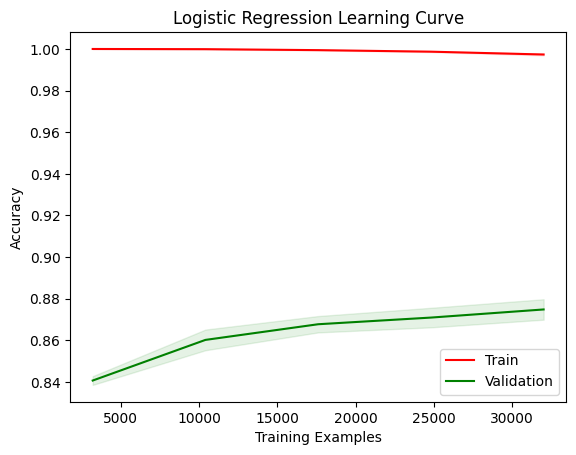

Logistic Regression Accuracy: 0.873
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3984
           1       0.87      0.88      0.87      4016

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000



C:\Users\ma\Desktop\nlpenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
lr_model_bow = train_and_evaluate(bow_matrix, train_df['sentiment'],
                              model_type='logistic_regression',
                              draw_learning_curve=True)

The ROC AUC curves indicate that our model performs well in terms of prediction capability. Other models are expected to show similar results. However, since our dataset is well-balanced, using ROC AUC might be unnecessary.

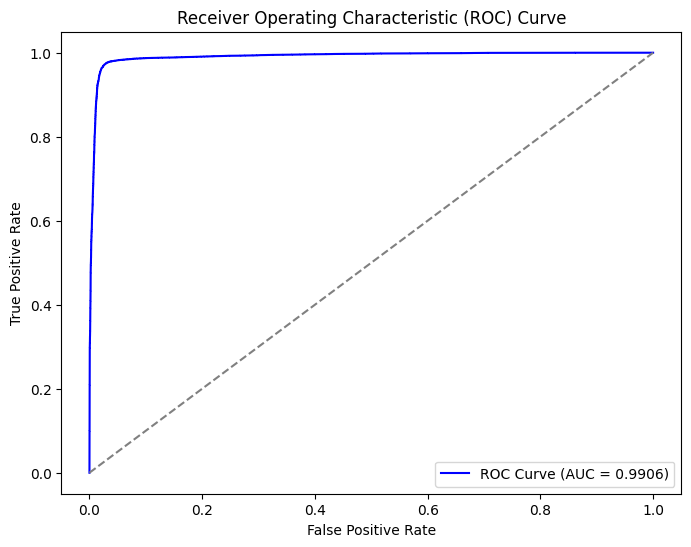

In [30]:
plot_roc_curve(lr_model_bow, bow_matrix, train_df['sentiment'])

With **TF-IDF**, we achieved better results because assigning importance to words improved generalization. While the **BoW** method yielded high accuracy, it overfitted easily. In contrast, **TF-IDF** provided more balanced accuracy, and the graphs indicate a well-performing model.

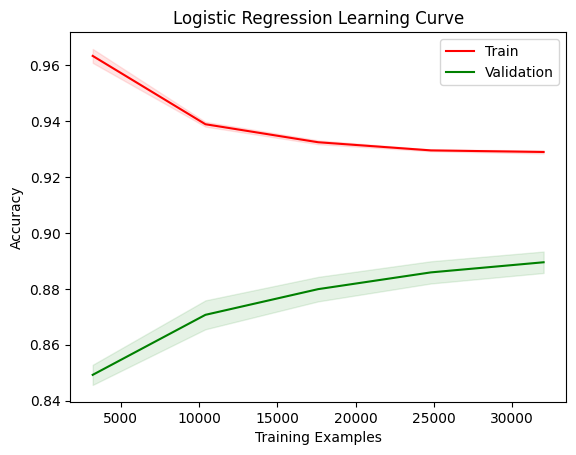

Logistic Regression Accuracy: 0.884375
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3984
           1       0.87      0.90      0.89      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



In [31]:
lr_model_tfidf = train_and_evaluate(tfidf_matrix_ngram, train_df['sentiment'],
                              model_type='logistic_regression',
                              draw_learning_curve=True)

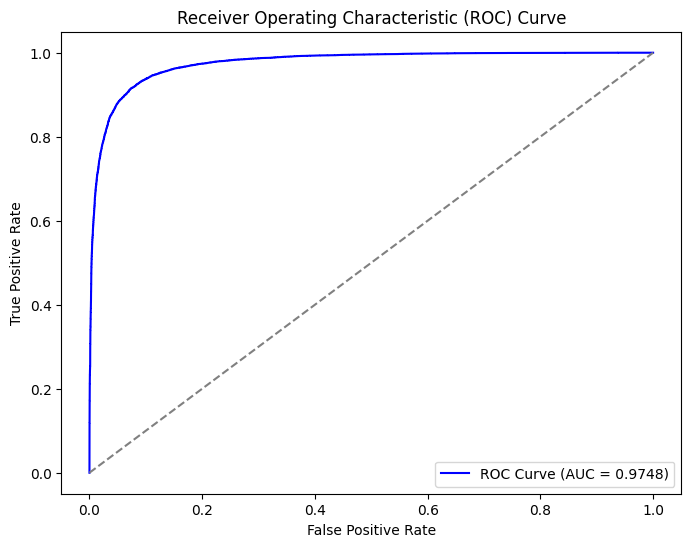

In [32]:
plot_roc_curve(lr_model_tfidf, tfidf_matrix_ngram, train_df['sentiment'])

After **10 experiments**, I obtained these results. The **neural network configuration** was the most time-consuming, as it easily overfitted due to the high number of features. However, since I achieved good results with other models, I didn’t spend too much time on **dimensionality reduction** or other methods. In this early approach, model training performed well, though **validation might still benefit from tuning epochs**.

C:\Users\ma\Desktop\nlpenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


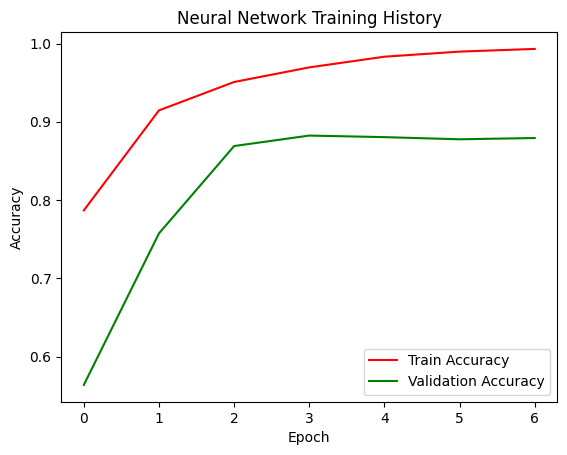

Neural Network Test Accuracy: 0.8824


In [33]:
nn_model_tfidf = train_and_evaluate(tfidf_matrix_ngram, train_df['sentiment'],
                              model_type='neural_network',
                              draw_learning_curve=True)

Here, we obtained another good graph and results using **TF-IDF** with **LinearSVC**. The results are very similar to those of **Logistic Regression**.

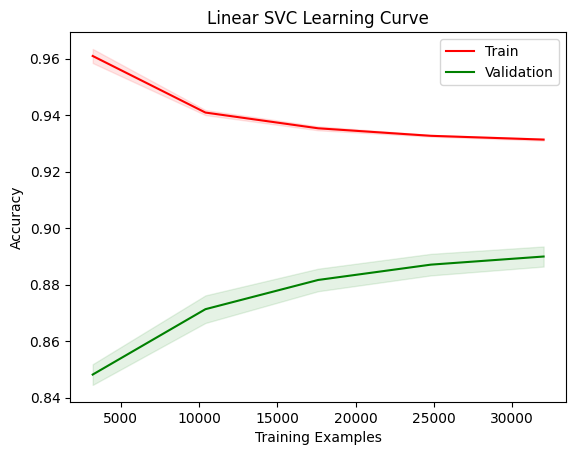

Linear SVC Accuracy: 0.886125
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3984
           1       0.87      0.91      0.89      4016

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



In [34]:
linearsvc_tfidf = train_and_evaluate(tfidf_matrix_ngram, train_df['sentiment'],
                              model_type='linear_svc',
                              draw_learning_curve=True)

With **BoW**, models like **Logistic Regression** easily overfit. Additionally, I couldn't effectively use **TF-IDF** with the neural network. Before implementing the models, I initially presumed that **TF-IDF** would be the better choice, as BoW is a more naive method. However, the extent of overfitting with BoW was somewhat surprising.

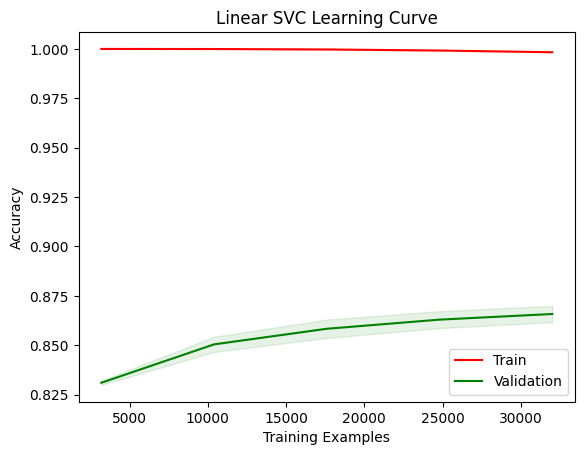

Linear SVC Accuracy: 0.863875
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3984
           1       0.86      0.86      0.86      4016

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000



In [35]:
linearsvc_bow = train_and_evaluate(bow_matrix, train_df['sentiment'],
                              model_type='linear_svc',
                              draw_learning_curve=True)

In the training phase, **LinearSVC** and **Logistic Regression** are the best performers. **Neural networks** are overkill for this project and require significantly more resources.

In [36]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the given model on test data.
    
    Parameters:
    model: Trained model to use for predictions.
    X_test: Test feature matrix (TF-IDF or other vectorized format).
    y_test: True sentiment labels.
    
    """

    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    print(classification_report(y_test, y_pred))


Here, we will compare all models again using the **test dataset**, and I will use the **TF-IDF vectorizer** for evaluation.

Now, all models produced similar results with **TF-IDF**, while **BoW failed again** in a more interpretable way. The models performed similarly because they effectively handled **50K sentiment analysis samples** with only **two classes**. 

I prefer **Logistic Regression** since **Neural Networks** are more computationally intensive while yielding similar results. **LinearSVC** and **Logistic Regression** performed similarly, but **LinearSVC cannot produce probability-based outputs**. Considering **interpretability, computational efficiency, and simplicity**, the **best model for binary classification is Logistic Regression**.

In [37]:
test_df['review_prep'] = test_df['review'].apply(lambda x: preprocess_text(x, slang_dict))

In [38]:
test_df["tokenized"] = spacy_batch_tokenizer(test_df["review_prep"].tolist())

In [39]:
test_df["lemmatized"] = spacy_lemmatize(test_df["tokenized"].tolist())

In [40]:
tfidf_matrix_test = tfidf_vectorizer.transform(test_df['lemmatized'])

In [41]:
evaluate_model(lr_model_bow, tfidf_matrix_test, test_df['sentiment'])

Accuracy: 0.8529
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      5000
           1       0.81      0.92      0.86      5000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



In [42]:
evaluate_model(lr_model_tfidf, tfidf_matrix_test, test_df['sentiment'])

Accuracy: 0.8905
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      5000
           1       0.88      0.91      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [43]:
evaluate_model(nn_model_tfidf, tfidf_matrix_test, test_df['sentiment'])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
Accuracy: 0.8879
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      5000
           1       0.89      0.88      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [44]:
evaluate_model(linearsvc_bow, tfidf_matrix_test, test_df['sentiment'])

Accuracy: 0.8376
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      5000
           1       0.79      0.91      0.85      5000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



In [45]:
evaluate_model(linearsvc_tfidf, tfidf_matrix_test, test_df['sentiment'])

Accuracy: 0.8926
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5000
           1       0.88      0.91      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Now, our **main model is Logistic Regression**. Here, we will perform **hyperparameter tuning** and determine the **deployment parameters** for our model.

Now, our **main model is Logistic Regression**. Here, we will perform **hyperparameter tuning** and determine the **deployment parameters** for our model.

In [46]:

random.seed(42)
np.random.seed(42)

def logistic_regression_hyperparameter_tuning(X_tfidf, y, test_size=0.2, random_state=42):
    """
    Perform hyperparameter tuning for Logistic Regression using GridSearchCV.
    
    Parameters:
        X_tfidf (array-like): TF-IDF feature matrix.
        y (array-like): Target labels.
        test_size (float): Proportion of dataset to be used as test set.
        random_state (int): Random state for reproducibility.
    
    Returns:
        best_model (LogisticRegression): Trained Logistic Regression model with best parameters.
    """
    from sklearn.model_selection import train_test_split
    
    # Split dataset into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Define hyperparameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l1', 'l2'],  # Regularization type
        'solver': ['liblinear'],  # Compatible with l1 & l2
        'max_iter': [200, 500, 1000] 
    }
    
    # Set up cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Perform Grid Search with Cross-Validation
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Best hyperparameters
    print("Best Parameters:", grid_search.best_params_)
    
    # Train final model with best parameters
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return best_model

In [47]:
best_model = logistic_regression_hyperparameter_tuning(tfidf_matrix_ngram, train_df['sentiment'], test_size=0.2, random_state=42)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy: 0.89125
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      4000
           1       0.88      0.91      0.89      4000

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



In [48]:
evaluate_model(best_model, tfidf_matrix_test, test_df['sentiment'])

Accuracy: 0.8929
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      5000
           1       0.88      0.91      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



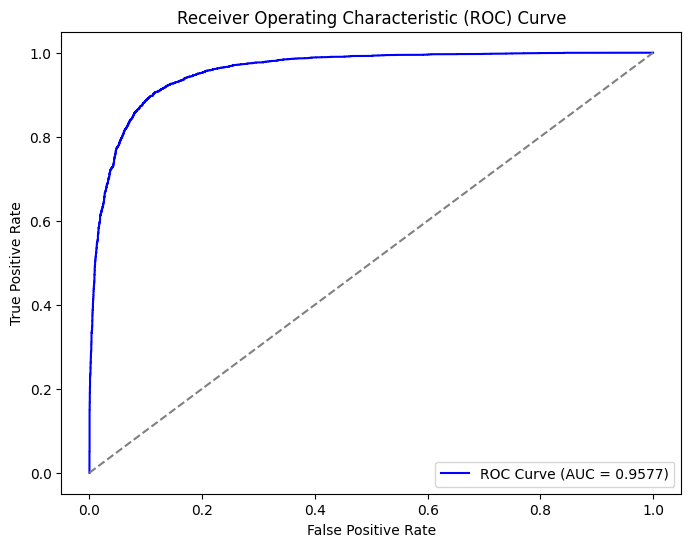

In [49]:
plot_roc_curve(best_model, tfidf_matrix_test, test_df['sentiment'])

### **Potential Business Applications and Value for Business**  

- **Movie Studios and Production Houses:**  
  Sentiment analysis helps studios fine-tune their marketing plans based on audience reactions. It also minimizes financial risks by enabling data-driven decisions on content creation.  

- **Streaming Platforms (Netflix, Amazon Prime, Disney+):**  
  Platforms can use sentiment insights to offer personalized content recommendations, enhancing user experience. Additionally, it helps them identify trending content, allowing for better investment in licensing and original productions.  

- **Movie Review Aggregators (IMDb, Rotten Tomatoes, Metacritic):**  
  Automated sentiment analysis summarizes reviews, making it easier for users to grasp overall opinions. This reduces information overload and increases engagement by providing real-time insights.  

- **Cinema Chains and Theaters:**  
  Theaters can utilize sentiment data to implement dynamic pricing, adjusting ticket prices based on predicted demand for specific movies.  

- **Investors and Financial Analysts:**  
  Sentiment analysis helps predict entertainment company stock performance by assessing audience reactions. It also aids investors in spotting industry trends and potential profitable opportunities.